In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pickle

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
#reading from pickle
with open('processed_df_final.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [4]:
df_vect = df.copy()

In [5]:
# creating a custom tokenizer that will only split words based on white space since multi-word genres 
# are formatted with dashes (-) to between the words
def my_tokenizer(text):
    # Split text into tokens based on whitespace characters
    tokens = re.split(r'\s+', text)
    return tokens

In [6]:
bagofwords = CountVectorizer(tokenizer=my_tokenizer).fit(df_vect['track_genre'])

/Users/ounnuqul/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [7]:
transformed = bagofwords.transform(df_vect['track_genre'])

In [8]:
vect_matrix = pd.DataFrame(columns=bagofwords.get_feature_names(), data=transformed.toarray())
vect_matrix.head()

/Users/ounnuqul/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,acoustic,afrobeat,alt-rock,alternative,ambient,anime,black-metal,bluegrass,blues,bossanova,...,summer,swedish,synth-pop,tango,techno,trance,trip-hop,turkish,work-out,world-music
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_vect = pd.concat([df_vect.reset_index(),vect_matrix],axis=1)

df_vect['popularity'] = np.where(df_vect['popularity'] >= np.median(df_vect['popularity']), 1, 0)

df_vect.info()

vect_rem, vect_test = train_test_split(df_vect, test_size=0.25, random_state=42,
                                     stratify=df_vect[['track_genre','popularity']])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60434 entries, 0 to 60433
Columns: 149 entries, index to world-music
dtypes: float64(11), int64(131), object(7)
memory usage: 68.7+ MB


In [13]:
X_rem = vect_rem.drop(columns=['track_id', 'album_name', 'artists', 'track_name', 'track_genre',
       'href', 'preview_url','popularity'])
y_rem = vect_rem['popularity']

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
# estimator
estimator = Pipeline([
    ('rf', RandomForestClassifier())
])


# parameters
params = {
    'rf__max_depth':[5,10,15,None],
    'rf__n_estimators': [50,75,100],
    'rf__min_samples_leaf':[2,4,6,8,10],
    'rf__criterion': ['gini','entropy']
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('RandomForest_grid_1.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


In [21]:
grid.best_params_

{'rf__criterion': 'entropy',
 'rf__max_depth': None,
 'rf__min_samples_leaf': 2,
 'rf__n_estimators': 100}

In [22]:
grid.best_score_

0.71715388858246

In [23]:

X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2, random_state=42)
train_acc = []
train_pre = []
train_f1 = []
train_rec = []

val_acc = []
val_pre = []
val_f1 = []
val_rec = []
for x in range(50,150,10):
    rf = RandomForestClassifier(n_estimators=x, criterion='entropy',min_samples_leaf=2).fit(X_train,y_train)
    print(f'n_estimators = {x}')
    y_pred = rf.predict(X_train)
    print(f'Train Accuracy Score: {accuracy_score(y_pred,y_train)}')
    print(f'Train Recall Score: {recall_score(y_pred,y_train)}')
    print(f'Train Precision Score: {precision_score(y_pred,y_train)}')
    print(f'Train F1 Score: {f1_score(y_pred,y_train)}')
    
    train_acc.append(accuracy_score(y_pred,y_train))
    train_pre.append(recall_score(y_pred,y_train))
    train_f1.append(precision_score(y_pred,y_train))
    train_rec.append(f1_score(y_pred,y_train))
    
    print('\n')
    
    y_pred1 = rf.predict(X_val)
    print(f'Validation Accuracy Score: {accuracy_score(y_pred1,y_val)}')
    print(f'Validation Recall Score: {recall_score(y_pred1,y_val)}')
    print(f'Validation Precision Score: {precision_score(y_pred1,y_val)}')
    print(f'Validation F1 Score: {f1_score(y_pred1,y_val)}')
    
    val_acc.append(accuracy_score(y_pred1,y_val))
    val_pre.append(recall_score(y_pred1,y_val))
    val_f1.append(precision_score(y_pred1,y_val))
    val_rec.append(f1_score(y_pred1,y_val))
    print('\n')

n_estimators = 50
Train Accuracy Score: 0.9872311086596801
Train Recall Score: 0.9869512994103516
Train Precision Score: 0.9877602316813289
Train F1 Score: 0.9873555998579894


Validation Accuracy Score: 0.7166023166023165
Validation Recall Score: 0.7132586170437725
Validation Precision Score: 0.7354993458351504
Validation F1 Score: 0.7242082662372517


n_estimators = 60
Train Accuracy Score: 0.9897683397683398
Train Recall Score: 0.9893558951965066
Train Precision Score: 0.9903830391781869
Train F1 Score: 0.9898692007318205


Validation Accuracy Score: 0.7178157749586321
Validation Recall Score: 0.7163892445582587
Validation Precision Score: 0.7320104666375927
Validation F1 Score: 0.7241156169111304


n_estimators = 70
Train Accuracy Score: 0.9905681191395477
Train Recall Score: 0.9903347348877847
Train Precision Score: 0.9909840992295503
Train F1 Score: 0.9906593106462008


Validation Accuracy Score: 0.7162713734142305
Validation Recall Score: 0.7125369354157872
Validation Precision 

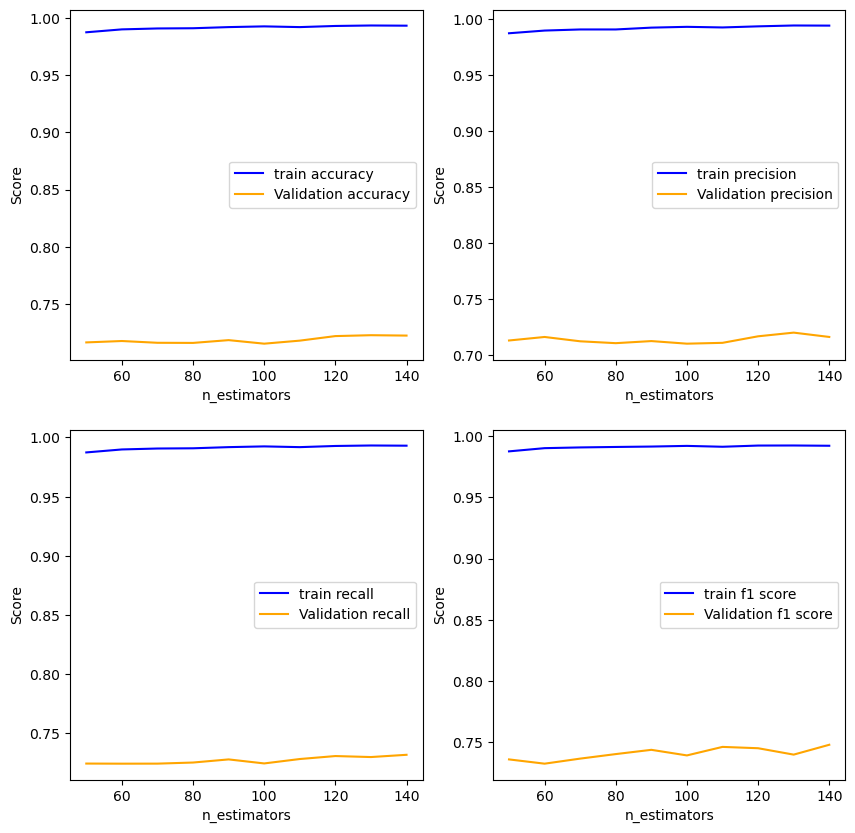

In [24]:
#Exploring the effect of n_estimators on overfitting
plt.subplots(2,2,figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(range(50,150,10),train_acc,label='train accuracy',color='blue')
plt.plot(range(50,150,10),val_acc,label='Validation accuracy',color='orange')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Score')


plt.subplot(2,2,2)
plt.plot(range(50,150,10),train_pre,label='train precision',color='blue')
plt.plot(range(50,150,10),val_pre,label='Validation precision',color='orange')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Score')


plt.subplot(2,2,3)
plt.plot(range(50,150,10),train_rec,label='train recall',color='blue')
plt.plot(range(50,150,10),val_rec,label='Validation recall',color='orange')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Score')


plt.subplot(2,2,4)
plt.plot(range(50,150,10),train_f1,label='train f1 score',color='blue')
plt.plot(range(50,150,10),val_f1,label='Validation f1 score',color='orange')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Score')

plt.show()



In [26]:
acc_diff = []
for x in range(len(train_acc)):
    acc_diff.append(train_acc[x] - val_acc[x])

pd.DataFrame({'n_estimators':range(50,150,10),
              'train acc':train_acc,'val acc':val_acc,
              'accuracy diffrence':acc_diff})

,n_estimators,train acc,val acc,accuracy diffrence
0,50,0.987231,0.716602,0.270629
1,60,0.989768,0.717816,0.271953
2,70,0.990568,0.716271,0.274297
3,80,0.990761,0.716161,0.274600
4,90,0.991754,0.718588,0.273166
5,100,0.992388,0.715499,0.276889
6,110,0.991754,0.718147,0.273607
7,120,0.992747,0.722118,0.270629
8,130,0.993161,0.722890,0.270270
9,140,0.992995,0.722559,0.270436


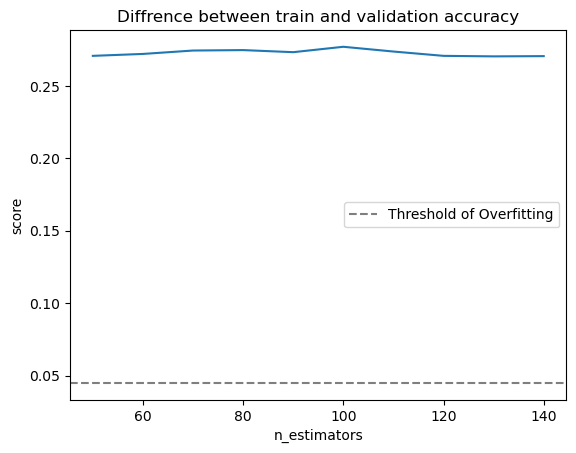

In [27]:
plt.figure()

plt.plot(range(50,150,10), acc_diff)
plt.title('Diffrence between train and validation accuracy')
plt.ylabel('score')
plt.xlabel('n_estimators')
plt.axhline(0.045, linestyle='--',color='black',label='Threshold of Overfitting', alpha=0.5)
plt.legend()

plt.show()

In [37]:
# estimator
estimator = Pipeline([
    ('rf', RandomForestClassifier())
])


# parameters
params = {
    'rf__n_estimators': [100],
    'rf__min_samples_leaf':[1,2,3],
    'rf__min_samples_split':[.25,.5,.75],
    'rf__criterion': ['gini','entropy']
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('RandomForest_grid_2.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__min_samples_leaf': [1, 2, 3],
                         'rf__min_samples_split': [0.25, 0.5, 0.75],
                         'rf__n_estimators': [100]},
             verbose=3)

In [38]:
grid.best_params_

{'rf__criterion': 'entropy',
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 0.25,
 'rf__n_estimators': 100}

In [39]:
grid.best_score_

0.5981467181467182

In [34]:
# estimator
estimator = Pipeline([
    ('rf', RandomForestClassifier())
])


# parameters
params = {
    'rf__n_estimators': [100],
    'rf__min_samples_leaf':[1,2,3],
    #'rf__min_samples_split':[.25,.5,.75],
    'rf__criterion': ['gini','entropy']
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('RandomForest_grid_3.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [35]:
grid.best_params_

{'rf__criterion': 'entropy',
 'rf__min_samples_leaf': 1,
 'rf__n_estimators': 100}

In [36]:
grid.best_score_

0.721676778819636